In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import torch
import matplotlib.pyplot as plt

In [2]:
config_file = './configs/lego_tiny.yaml'
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

In [3]:
from utils.DataLoaderLego import DataLoaderLego

data_loader = DataLoaderLego(config['data'])

images, poses, focal = data_loader.getDataset('train')

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()

In [5]:
from utils.Camera import Camera

cameras = []
H, W = images[0].shape[:2]

for i in range(images.shape[0]):
    cameras.append(Camera(H, W, poses[i], focal, device))


In [6]:
from utils.Renderer import Renderer

renderer = Renderer(config['renderer'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
6
Epoch: 0, Average loss: 0.002036851132288575, Secs per iter: 0.008098607063293456
Test PSNR: 7.071910381317139
torch.Size([10000, 3])


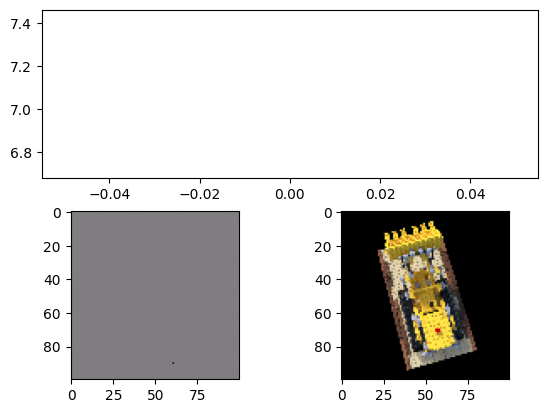

Epoch: 100, Average loss: 0.08041749894618988, Secs per iter: 0.12452404737472535
Test PSNR: 12.125856399536133
torch.Size([10000, 3])


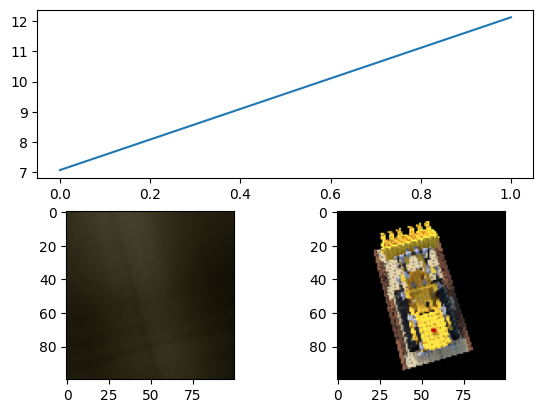

Epoch: 200, Average loss: 0.06325879693031311, Secs per iter: 0.12434038400650024
Test PSNR: 12.799578666687012
torch.Size([10000, 3])


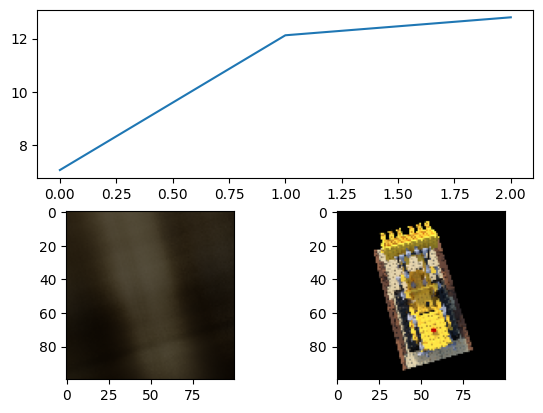

Epoch: 300, Average loss: 0.04356915503740311, Secs per iter: 0.12435141801834107
Test PSNR: 15.633584976196289
torch.Size([10000, 3])


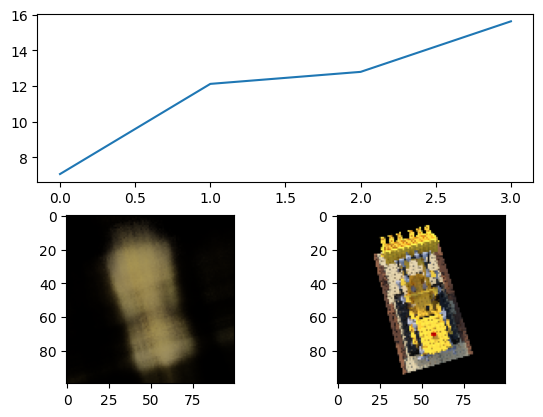

Epoch: 400, Average loss: 0.022725073620676994, Secs per iter: 0.12440657138824462
Test PSNR: 17.328584671020508
torch.Size([10000, 3])


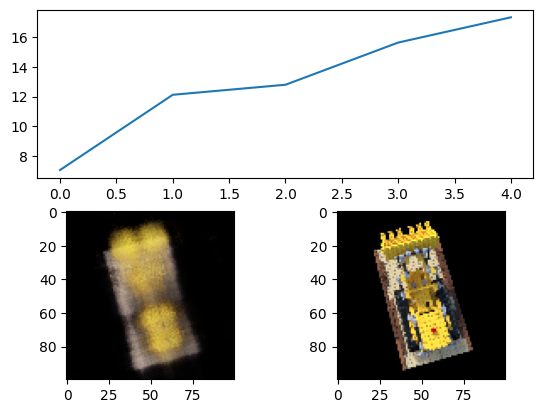

Epoch: 500, Average loss: 0.017441026866436005, Secs per iter: 0.12428244829177856
Test PSNR: 17.565872192382812
torch.Size([10000, 3])


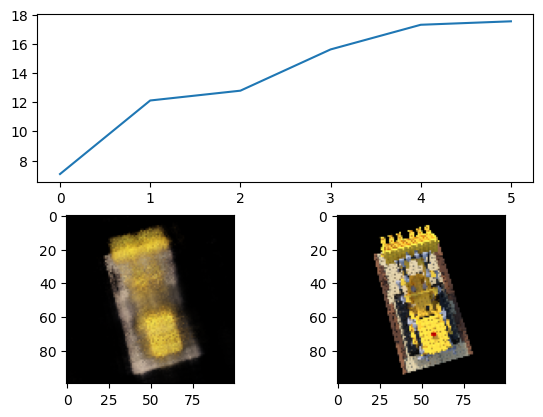

Epoch: 600, Average loss: 0.01476319320499897, Secs per iter: 0.12433932065963745
Test PSNR: 18.152584075927734
torch.Size([10000, 3])


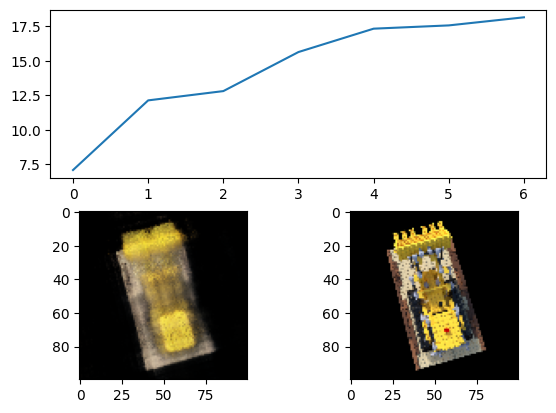

Epoch: 700, Average loss: 0.013905936852097511, Secs per iter: 0.12441355228424072
Test PSNR: 18.116580963134766
torch.Size([10000, 3])


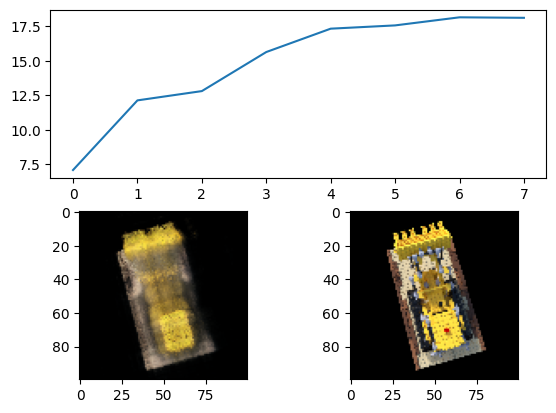

Epoch: 800, Average loss: 0.012994728051126003, Secs per iter: 0.12428077459335327
Test PSNR: 18.77039909362793
torch.Size([10000, 3])


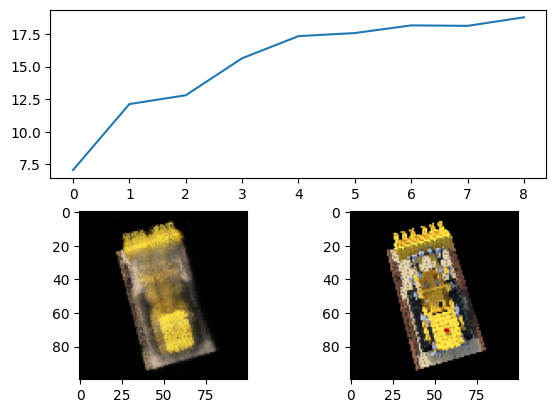

Epoch: 900, Average loss: 0.011326913721859455, Secs per iter: 0.12424197435379028
Test PSNR: 18.721546173095703
torch.Size([10000, 3])


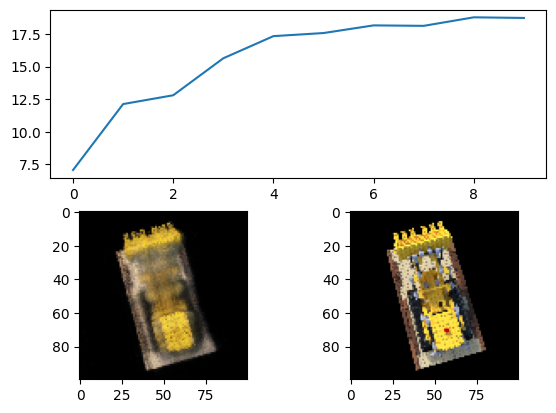

Epoch: 1000, Average loss: 0.010641872882843018, Secs per iter: 0.1251533532142639
Test PSNR: 19.205949783325195
torch.Size([10000, 3])


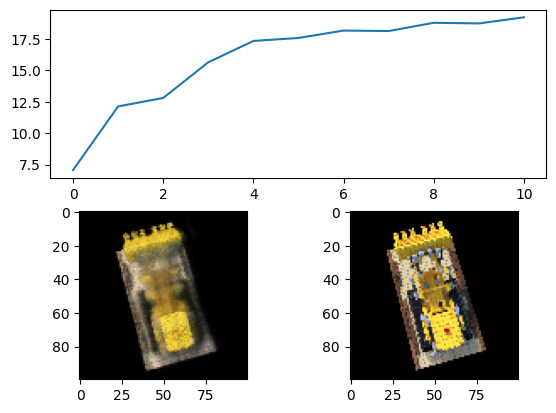

Epoch: 1100, Average loss: 0.010290579870343208, Secs per iter: 0.12432743549346924
Test PSNR: 19.219491958618164
torch.Size([10000, 3])


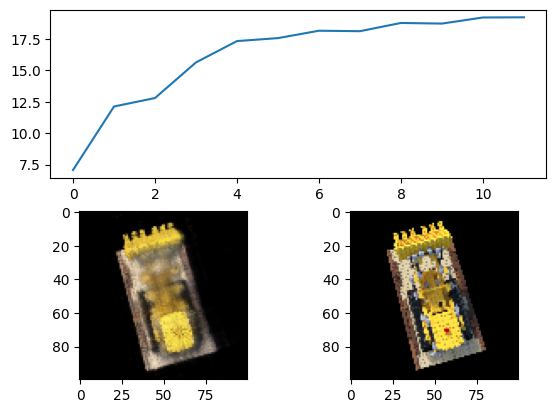

Epoch: 1200, Average loss: 0.009914054535329342, Secs per iter: 0.12431208133697509
Test PSNR: 19.592689514160156
torch.Size([10000, 3])


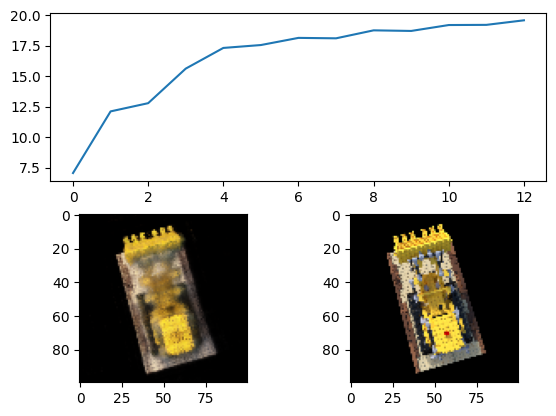

Epoch: 1300, Average loss: 0.009267142973840237, Secs per iter: 0.12421950578689575
Test PSNR: 19.425537109375
torch.Size([10000, 3])


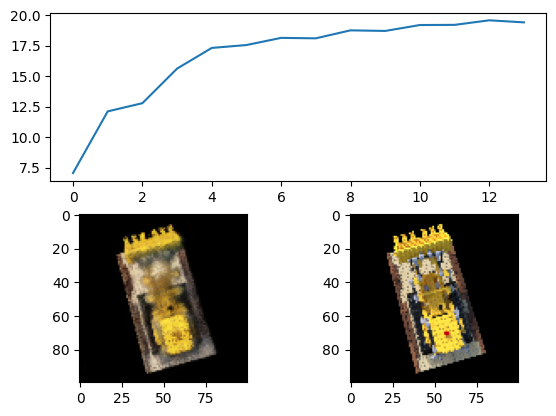

Epoch: 1400, Average loss: 0.00872267410159111, Secs per iter: 0.12419876337051391
Test PSNR: 19.969390869140625
torch.Size([10000, 3])


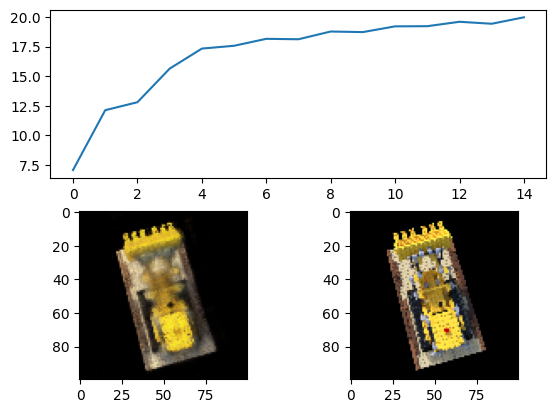

Epoch: 1500, Average loss: 0.008671554736793041, Secs per iter: 0.1241800045967102
Test PSNR: 19.736400604248047
torch.Size([10000, 3])


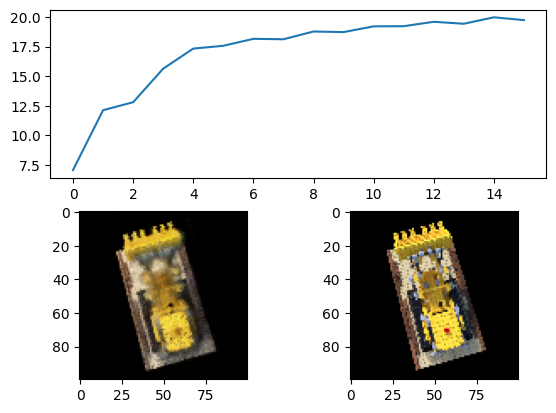

Epoch: 1600, Average loss: 0.00877636019140482, Secs per iter: 0.12516123294830322
Test PSNR: 19.725095748901367
torch.Size([10000, 3])


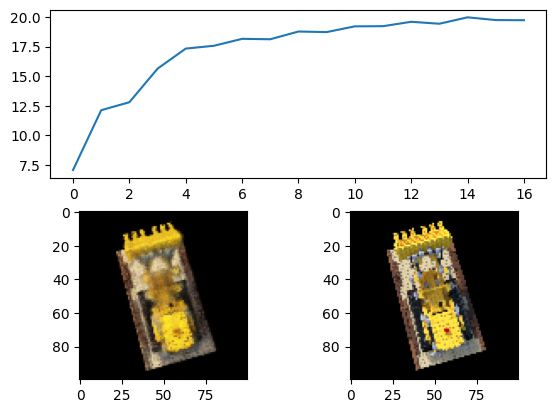

Epoch: 1700, Average loss: 0.008134675212204456, Secs per iter: 0.12431452989578247
Test PSNR: 19.711090087890625
torch.Size([10000, 3])


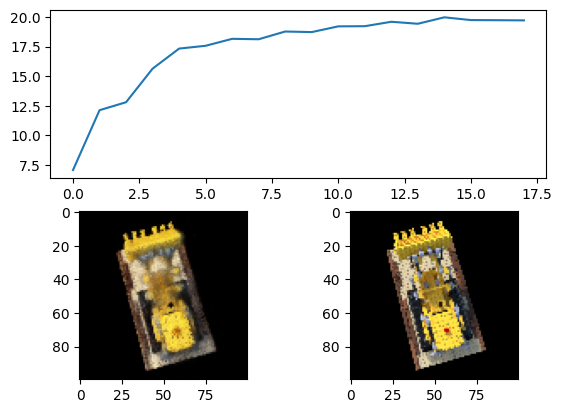

Epoch: 1800, Average loss: 0.007982208393514156, Secs per iter: 0.12420753002166748
Test PSNR: 20.011728286743164
torch.Size([10000, 3])


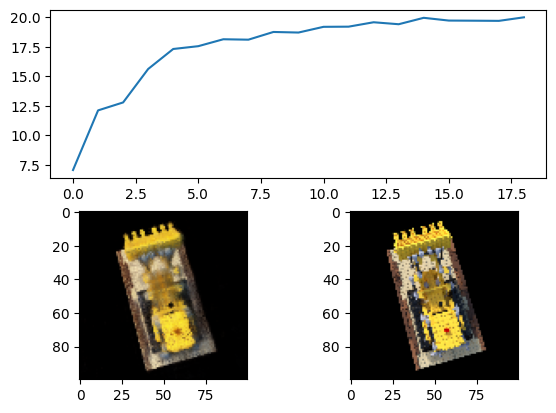

Epoch: 1900, Average loss: 0.007757050916552544, Secs per iter: 0.12442477703094483
Test PSNR: 20.183382034301758
torch.Size([10000, 3])


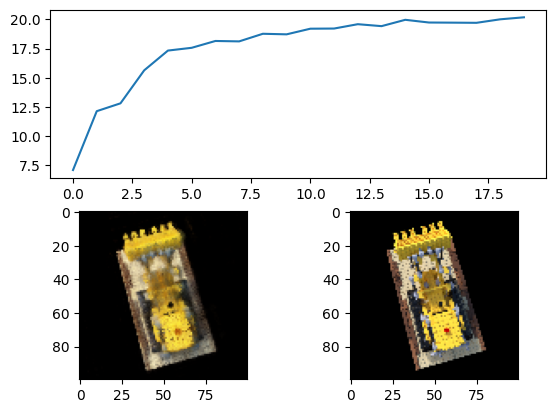

Epoch: 2000, Average loss: 0.007555714808404446, Secs per iter: 0.12519845247268677
Test PSNR: 20.29598045349121
torch.Size([10000, 3])


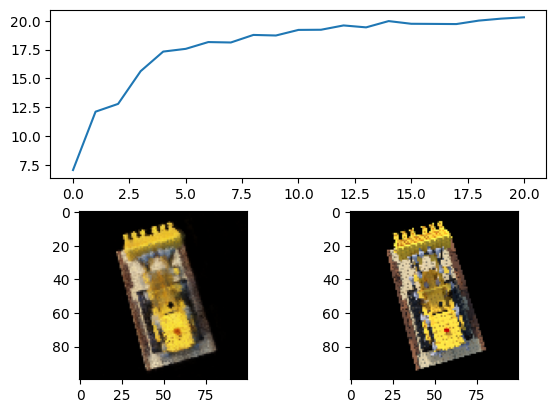

Epoch: 2100, Average loss: 0.007383708842098713, Secs per iter: 0.12441250324249267
Test PSNR: 19.821516036987305
torch.Size([10000, 3])


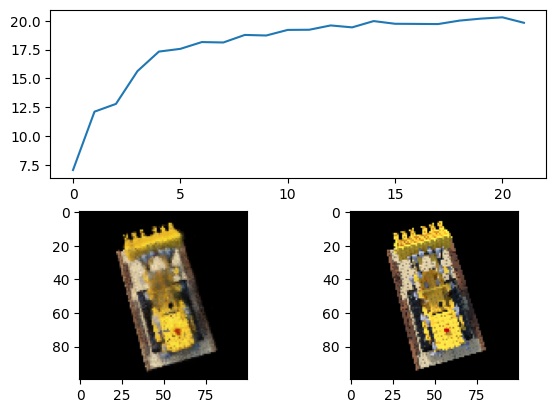

Epoch: 2200, Average loss: 0.007169797550886869, Secs per iter: 0.12443517446517945
Test PSNR: 19.907167434692383
torch.Size([10000, 3])


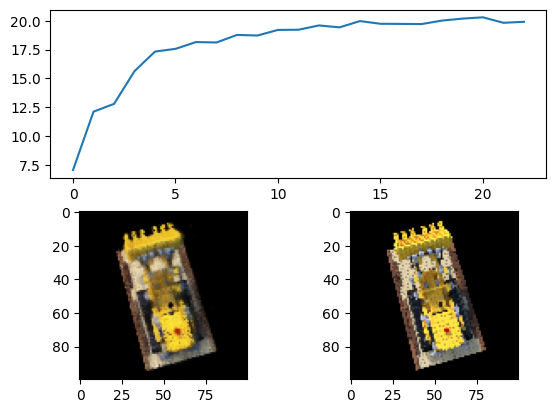

Epoch: 2300, Average loss: 0.0071109444834291935, Secs per iter: 0.12432230710983276
Test PSNR: 20.245738983154297
torch.Size([10000, 3])


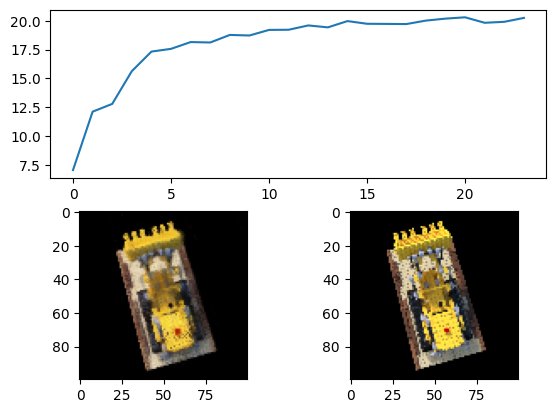

Epoch: 2400, Average loss: 0.007178357802331448, Secs per iter: 0.12418226242065429
Test PSNR: 20.235815048217773
torch.Size([10000, 3])


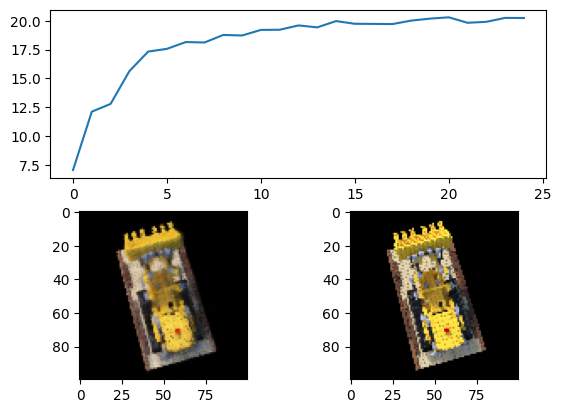

Epoch: 2500, Average loss: 0.006817809771746397, Secs per iter: 0.12424019575119019
Test PSNR: 20.37175750732422
torch.Size([10000, 3])


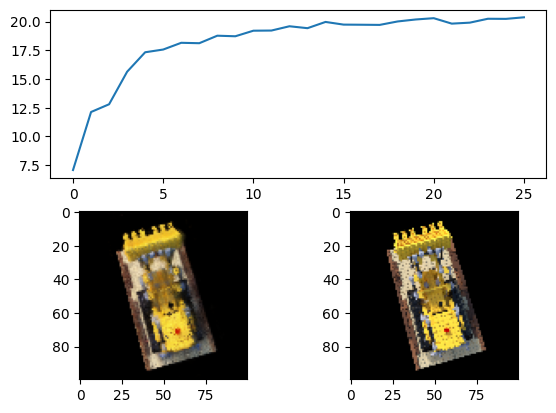

Epoch: 2600, Average loss: 0.006662809755653143, Secs per iter: 0.12422603130340576
Test PSNR: 20.25655746459961
torch.Size([10000, 3])


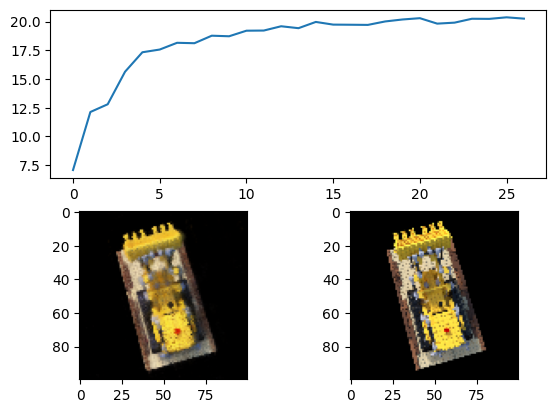

Epoch: 2700, Average loss: 0.0064614154398441315, Secs per iter: 0.1242660140991211
Test PSNR: 20.32160758972168
torch.Size([10000, 3])


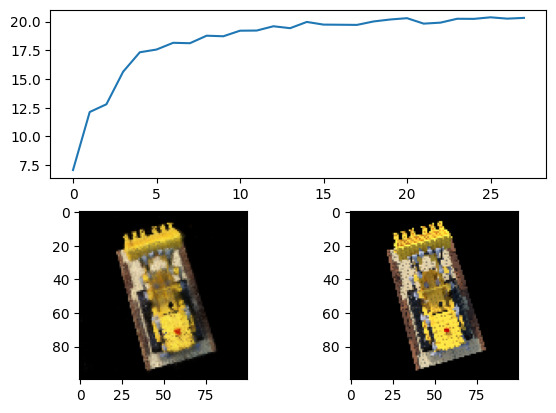

Epoch: 2800, Average loss: 0.006410092581063509, Secs per iter: 0.12423976421356202
Test PSNR: 20.13871192932129
torch.Size([10000, 3])


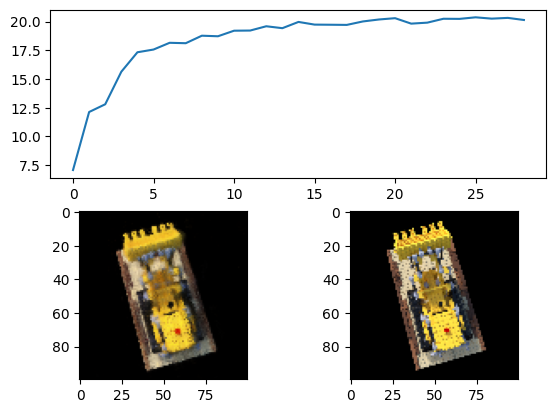

Epoch: 2900, Average loss: 0.006396498065441847, Secs per iter: 0.12424249172210694
Test PSNR: 20.06008529663086
torch.Size([10000, 3])


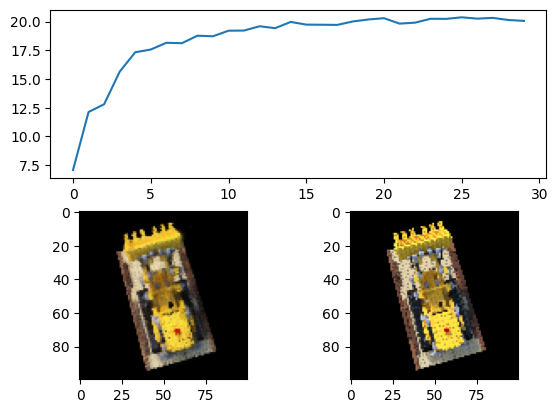

Epoch: 3000, Average loss: 0.006296634208410978, Secs per iter: 0.12525469303131104
Test PSNR: 19.642255783081055
torch.Size([10000, 3])


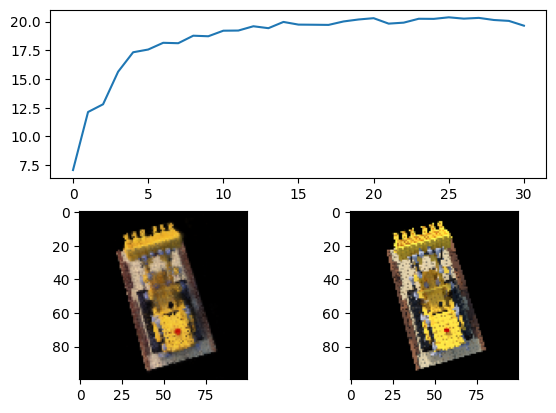

Epoch: 3100, Average loss: 0.006538267247378826, Secs per iter: 0.12421159744262696
Test PSNR: 20.097549438476562
torch.Size([10000, 3])


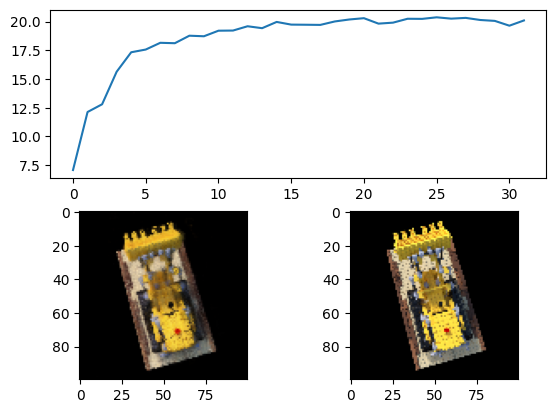

Epoch: 3200, Average loss: 0.0065878573805093765, Secs per iter: 0.12415285348892212
Test PSNR: 20.488204956054688
torch.Size([10000, 3])


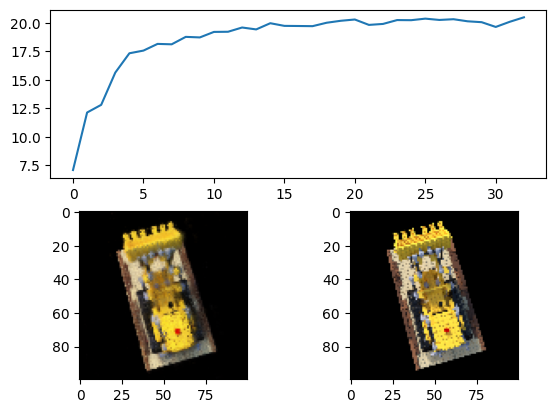

Epoch: 3300, Average loss: 0.006271475926041603, Secs per iter: 0.12431690692901612
Test PSNR: 20.504465103149414
torch.Size([10000, 3])


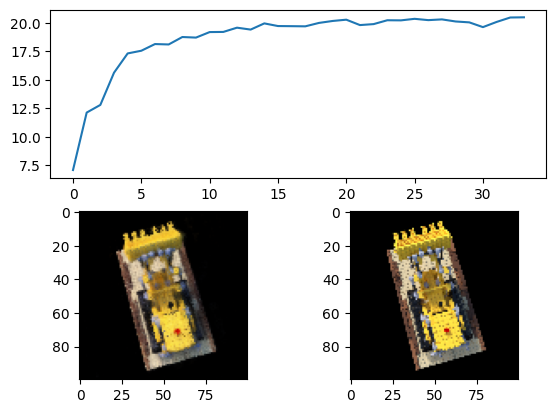

Epoch: 3400, Average loss: 0.00615253672003746, Secs per iter: 0.12427188634872437
Test PSNR: 20.131637573242188
torch.Size([10000, 3])


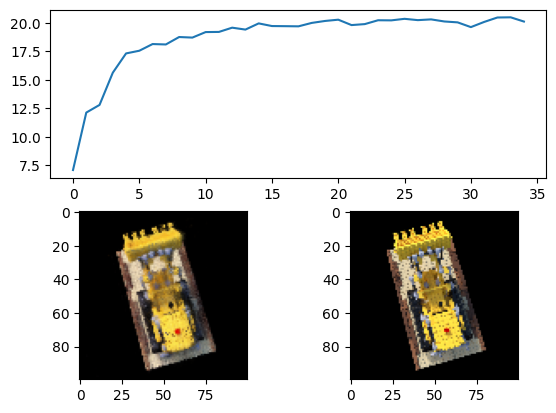

Epoch: 3500, Average loss: 0.006067013833671808, Secs per iter: 0.12433519124984742
Test PSNR: 20.387317657470703
torch.Size([10000, 3])


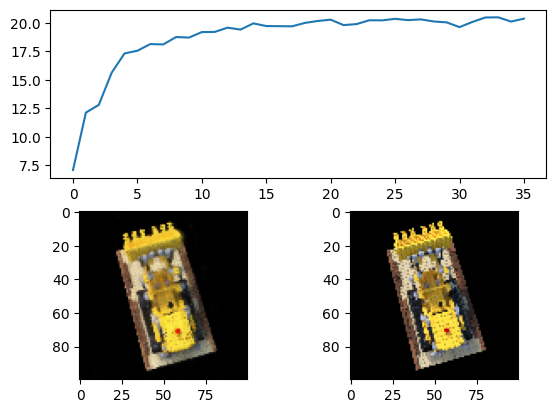

Epoch: 3600, Average loss: 0.006042805965989828, Secs per iter: 0.12426431655883789
Test PSNR: 20.498455047607422
torch.Size([10000, 3])


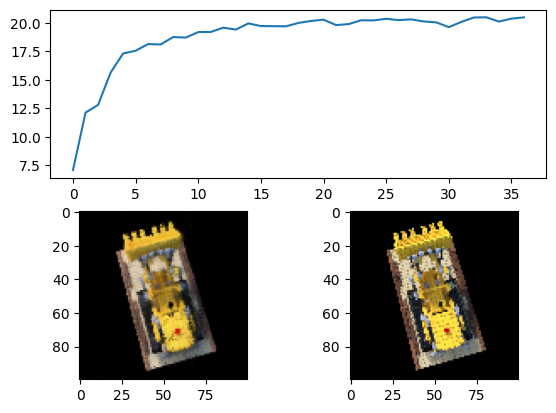

Epoch: 3700, Average loss: 0.006014572456479073, Secs per iter: 0.12422484636306763
Test PSNR: 20.282787322998047
torch.Size([10000, 3])


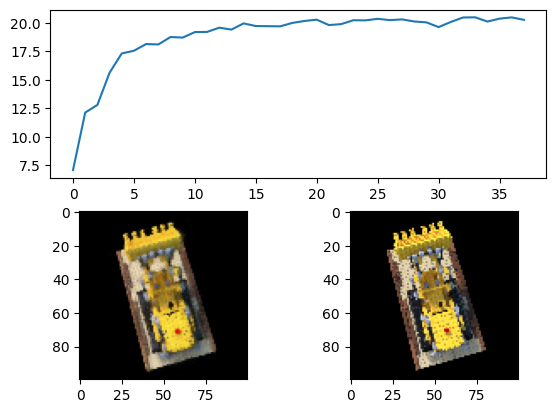

Epoch: 3800, Average loss: 0.005988791584968567, Secs per iter: 0.12424951314926147
Test PSNR: 20.308387756347656
torch.Size([10000, 3])


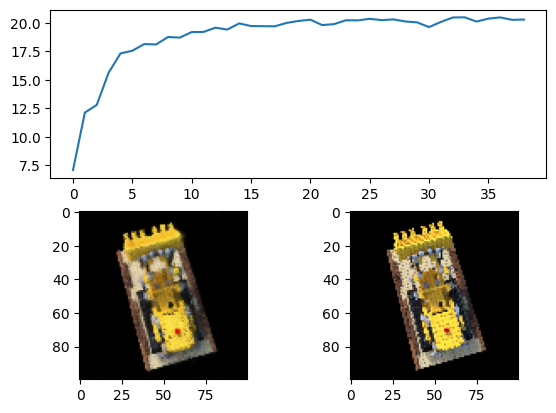

Epoch: 3900, Average loss: 0.0060631753876805305, Secs per iter: 0.12427998065948487
Test PSNR: 20.500476837158203
torch.Size([10000, 3])


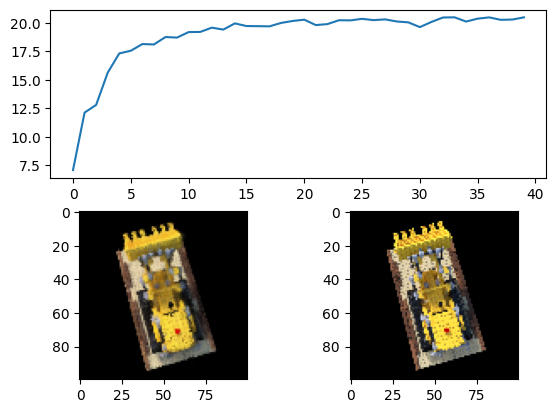

Epoch: 4000, Average loss: 0.005958838388323784, Secs per iter: 0.12512216091156006
Test PSNR: 20.263784408569336
torch.Size([10000, 3])


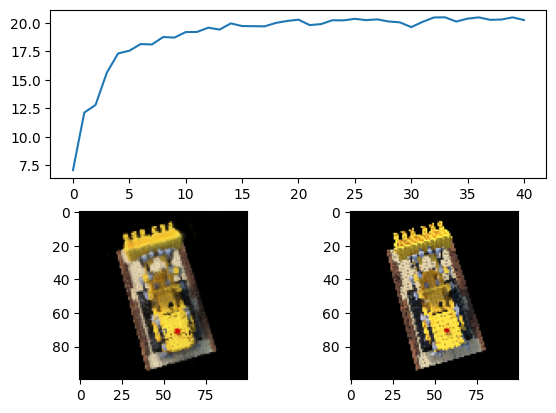

Epoch: 4100, Average loss: 0.005956774577498436, Secs per iter: 0.1243677544593811
Test PSNR: 20.318206787109375
torch.Size([10000, 3])


In [ ]:
%load_ext autoreload
%autoreload 2


from models.TinyNerf import TinyNerf
from utils.TrainerTinyNerf import TrainerTinyNerf
import imageio.v3 as iio

test_img = "nerf_synthetic/lego/val/r_0.png"
test_img = iio.imread(test_img)[:,:,:3]
test_img = torch.tensor(test_img)
test_img = torch.nn.functional.interpolate(test_img[None,...].permute(
            0, 3, 1, 2), (100, 100), mode='bilinear', align_corners=False).permute(0, 2, 3, 1)[0]
test_img = test_img/255

test_pose = torch.tensor([
                [
                    -0.963964581489563,
                    -0.2611401677131653,
                    0.0507759265601635,
                    0.2046843022108078
                ],
                [
                    0.26603081822395325,
                    -0.9462433457374573,
                    0.18398693203926086,
                    0.7416750192642212
                ],
                [
                    7.450580596923828e-09,
                    0.1908649355173111,
                    0.9816163182258606,
                    3.957021951675415
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

model = TinyNerf(config['model']['L_xyz'])
trainer = TrainerTinyNerf(model, device, images, cameras, renderer, config['trainer'])
trainer.train(test_img[None,...], test_pose[None,...], focal)